# Purpose


2021-10-11: <br>
The ETA for aggregating posts + comments is about 3 hours because I'm doing it in a loop (each loop = 1 post ID).  

In this notebook: How can we do aggregations faster?
- vectorize groupby + weighted average
    - Research
- parallelize groupby + weighted average
    - Try `dask.delayed()`
- something else?


---

2021-10-06:
We're going back to pandas now that I have the VM machine with a ton of RAM.

There might be some tweaks needed to batch a few subreddits at a time, but at least we can get more consistent state/progress than with `dask`.

---
2021-10-06:
The job with dask failed silently - even with 3+ TB of RAM.  `Dask` was reporting that saving was complete - but it only saved one `parquet` file instead of hundreds of files.

New direction: now that I have access to a large VM, I might as well try to go back and do the calculations in memory (in pandas).


-- 
2021-10-05:
I ran into memory errors with 600GB or RAM, so here's a try with 1.4TB... if this doesn't work. Then I don't know what will...

---

2021-08-10: Finally completed testing with sampling <= 10 files. Now ready to run process on full data!

Ended up doing it all in dask + pandas + numpy because of problems installing `cuDF`.

---
2021-08-02: Now that I'm processing millions of comments and posts, I need to re-write the functions to try to do some work in parallel and reduce the amount of data loaded in RAM.

- `Dask` seems like a great option to load data and only compute some of it as needed.
- `cuDF` could be a way to speed up some computation using GPUs
- `Dask-delayed` could be a way to create a task DAG lazily before computing all the aggregates.


---

In notebook 09 I combined embeddings from posts & subreddits (`djb_09.00-combine_post_and_comments_and_visualize_for_presentation.ipynb`).

In this notebook I'll be testing functions that include mlflow so that it's easier to try a lot of different weights to find better respresentations.

Take embeddings created by other models & combine them:
```
new post embeddings = post + comments + subreddit description

new subreddit embeddings = new posts (weighted by post length or upvotes?)
```

# Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
from datetime import datetime
import gc
import os
import logging
from pprint import pprint

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import dask
from dask import dataframe as dd
from tqdm import tqdm

import mlflow
import hydra

import subclu
from subclu.models.aggregate_embeddings import (
    AggregateEmbeddings, AggregateEmbeddingsConfig,
    load_config_agg_jupyter, get_dask_df_shape,
)
from subclu.models import aggregate_embeddings_pd

from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric
)
from subclu.utils.mlflow_logger import MlflowLogger, save_pd_df_to_parquet_in_chunks
from subclu.eda.aggregates import (
    compare_raw_v_weighted_language
)
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)


print_lib_versions([dask, hydra, mlflow, np, pd, plotly, sns, subclu])

python		v 3.7.10
===
dask		v: 2021.06.0
hydra		v: 1.1.0
mlflow		v: 1.16.0
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.4.0


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas')

,experiment_id,name,artifact_location,lifecycle_stage
0,0,Default,./mlruns/0,active
1,1,fse_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/1,active
2,2,fse_vectorize_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/2,active
3,3,subreddit_description_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/3,active
4,4,fse_vectorize_v1.1,gs://i18n-subreddit-clustering/mlflow/mlruns/4,active
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active
9,9,v0.3.2_use_multi_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/9,active


## Get runs that we can use for embeddings aggregation jobs

In [6]:
%%time

df_mlf_runs =  mlf.search_all_runs(experiment_ids=[13, 14, 15, 16])
df_mlf_runs.shape

CPU times: user 124 ms, sys: 7.07 ms, total: 131 ms
Wall time: 132 ms


(65, 127)

In [7]:
mask_finished = df_mlf_runs['status'] == 'FINISHED'
mask_output_over_1M_rows = (
    (df_mlf_runs['metrics.df_vect_posts_rows'] >= 1e5) |
    (df_mlf_runs['metrics.df_vect_comments'] >= 1e5)
)
# df_mlf_runs[mask_finished].shape

df_mlf_use_for_agg = df_mlf_runs[mask_output_over_1M_rows]
df_mlf_use_for_agg.shape

(3, 127)

In [8]:
cols_with_multiple_vals = df_mlf_use_for_agg.columns[df_mlf_use_for_agg.nunique(dropna=False) > 1]
# len(cols_with_multiple_vals)

style_df_numeric(
    df_mlf_use_for_agg
    [cols_with_multiple_vals]
    .drop(['artifact_uri', 'end_time',
           # 'start_time',
           ], 
          axis=1)
    .dropna(axis='columns', how='all')
    .iloc[:, :30]
    ,
    rename_cols_for_display=True,
)

,run id,experiment id,start time,metrics.vectorizing time minutes full function,metrics.vectorizing time minutes comments,metrics.df vect comments,metrics.total comment files processed,params.n comment files slice end,params.n comment files slice start,params.n sample comment files,params.tf batch inference rows,tags.mlflow.runName,tags.model version
39,deb3454ece2a4a8d8e4149c2d8494c0d,14,2021-10-05 01:44:32.386000+00:00,45.94,39.11,"10,121,046.00",15.00,None,None,15,3200,comments_batch_01-2021-10-05_014431,None
40,5f10cd75334142168a6ebb787e477c1f,14,2021-10-05 00:22:20.334000+00:00,57.33,47.64,"13,558,304.00",20.00,None,None,20,4200,comments_batch_01-2021-10-05_002219,0.4.0
44,9a27f9a72cf348c98d50f486abf3b009,13,2021-10-04 22:21:46.401000+00:00,5.03,3.93,"1,286,661.00",2.00,None,None,2,6000,posts_as_comments_full_text-2021-10-04_222146,None


# Load configs for aggregation jobs

`n_sample_comments_files` and `n_sample_posts_files` allow us to only load a few files at a time (e.g., 2 instead of 50) to test the process end-to-end.

---
Note that by default `hydra` is a cli tool. If we want to call use it in jupyter, we need to manually initialize configs & compose the configuration. See my custom function `load_config_agg_jupyter`. Also see:
- [Notebook with `Hydra` examples in a notebook](https://github.com/facebookresearch/hydra/blob/master/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb).
- [Hydra docs, Hydra in Jupyter](https://hydra.cc/docs/next/advanced/jupyter_notebooks/).


In [9]:
mlflow_experiment_test = 'v0.4.0_use_multi_aggregates_test'
mlflow_experiment_full = 'v0.4.0_use_multi_aggregates'

root_agg_config_name = 'aggregate_embeddings_v0.4.0'

config_test_sample_lc_false = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name=root_agg_config_name,
    overrides=[f"mlflow_experiment={mlflow_experiment_test}",
               'n_sample_posts_files=4',     # 
               'n_sample_comments_files=4',  # 6 is limit for logging unique counts at comment level
               # 'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_false',
              ]
)

config_full_lc_false = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name=root_agg_config_name,
    overrides=[f"mlflow_experiment={mlflow_experiment_full}",
               'n_sample_posts_files=null', 
               'n_sample_comments_files=null',
               # 'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_false',
              ]
)

# config_full_lc_true = AggregateEmbeddingsConfig(
#     config_path="../config",
#     config_name='aggregate_embeddings',
#     overrides=[f"mlflow_experiment={mlflow_experiment_full}",
#                'n_sample_posts_files=null', 
#                'n_sample_comments_files=null',
#                'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_true',
#               ]
# )
# pprint(config_test_sample_lc_false.config_dict, indent=2)

In [10]:
# config_test_sample_lc_false.config_flat,

In [11]:
df_configs = pd.DataFrame(
    [
        config_test_sample_lc_false.config_flat,
        # config_test_full_lc_false.config_flat,
        config_full_lc_false.config_flat,
        # config_full_lc_true.config_flat,
    ]
)

In [12]:
# We can't use (df_configs.nunique(dropna=False) > 1)
#  because when a col's content is a list or something unhashable, we get an error
#  so instead we'll check each column individually

# cols_with_diffs_config = df_configs.columns[df_configs.nunique(dropna=False) > 1]
cols_with_diffs_config = list()
for c_ in df_configs.columns:
    try:
        if df_configs[c_].nunique() > 1:
            cols_with_diffs_config.append(c_)
    except TypeError:
        cols_with_diffs_config.append(c_)
        

df_configs[cols_with_diffs_config]

,comments_vectorized_mlflow_uuids,posts_vectorized_mlflow_uuids,posts_vectorized_mlflow_uuids_lowercase,subreddit_meta_vectorized_mlflow_uuids,subreddit_meta_vectorized_mlflow_uuids_lowercase,comments_uuid,mlflow_experiment
0,"[5f10cd75334142168a6ebb787e477c1f, 2fcfefc3d5af43328168d3478b4fdeb6]",[8eef951842a34a6e81d176b15ae74afd],[537514ab3c724b10903000501802de0e],[8eef951842a34a6e81d176b15ae74afd],[537514ab3c724b10903000501802de0e],"[5f10cd75334142168a6ebb787e477c1f, 2fcfefc3d5af43328168d3478b4fdeb6]",v0.4.0_use_multi_aggregates_test
1,"[5f10cd75334142168a6ebb787e477c1f, 2fcfefc3d5af43328168d3478b4fdeb6]",[8eef951842a34a6e81d176b15ae74afd],[537514ab3c724b10903000501802de0e],[8eef951842a34a6e81d176b15ae74afd],[537514ab3c724b10903000501802de0e],"[5f10cd75334142168a6ebb787e477c1f, 2fcfefc3d5af43328168d3478b4fdeb6]",v0.4.0_use_multi_aggregates


In [13]:
# pprint(config_test_sample_lc_false.config_flat, indent=2)

# Debugging

# Run test with `lower_case=False

Sample only a few files in comments/ posts to make sure that job completes even when we're testing new code/logic.

Limit to only 2 files of each kind to get minimum test to run end to end.

But with 2 post files it still takes like 20 mins to go end-to-end. It might be better if I only use a single post-file to iterate faster.

### Load config

In [14]:
# run setup_logging() to remove logging to the file of a failed job
setup_logging()

In [15]:
logging.debug("debug test")
logging.info("info test")
logging.warning("warning message")
logging.error("error message")

05:04:15 | INFO | "info test"
05:04:15 | WARNING | "warning message"
05:04:15 | ERROR | "error message"


In [155]:
mlflow_experiment_test = 'v0.4.0_use_multi_aggregates_test'
mlflow_experiment_full = 'v0.4.0_use_multi_aggregates'

root_agg_config_name = 'aggregate_embeddings_v0.4.0'

config_test_sample_lc_false = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name=root_agg_config_name,
    overrides=[f"mlflow_experiment={mlflow_experiment_test}",
               'n_sample_posts_files=1',     # 
               'n_sample_comments_files=5',  # 6 is limit for logging unique counts at comment level
               'calculate_similarites=true',
               # 'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_false',
              ]
)

In [156]:
keys_to_check_in_config = ['mlflow_experiment', 'n_sample_posts_files', 'n_sample_comments_files', 'aggregate_params', 'calculate_similarites']

for k_ in keys_to_check_in_config:
    v_ = config_test_sample_lc_false.config_dict.get(k_)
    if isinstance(v_, dict):
        print(f"\n{k_}:")
        [print(f"  {k2_}: \t{v2_}") for k2_, v2_ in v_.items()]
    else:
        print(f"{k_}: \t{v_}")

mlflow_experiment: 	v0.4.0_use_multi_aggregates_test
n_sample_posts_files: 	1
n_sample_comments_files: 	5

aggregate_params:
  min_comment_text_len: 	2
  agg_comments_to_post_weight_col: 	None
  agg_post_to_subreddit_weight_col: 	None
  agg_post_post_weight: 	70
  agg_post_comment_weight: 	20
  agg_post_subreddit_desc_weight: 	10
calculate_similarites: 	True


In [159]:
BREAK

## Run test job/config


TODO: how to vectorize or run this in parallel?


It took around 9.5 minutes to go through 465k posts.
```bash
100%|██████████| 464967/464967 [09:21<00:00, 827.91it/s]
22:14:59 | INFO | "  (464967, 512) <- df_agg_posts_w_comments.shape (only posts with comments)"

```


In [158]:
%%time


gc.collect()
try:
    # run setup_logging() to remove logging to the file of a failed job
    job_agg_test._send_log_file_to_mlflow()
    setup_logging()
    del job_agg_test
except NameError:
    pass
gc.collect()
mlflow.end_run("FAILED")

job_agg_test = aggregate_embeddings_pd.AggregateEmbeddings(
    run_name=f"sample_test_lc_false_pd-{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    
    # use pre-loaded dfs
    df_v_sub=df_v_sub_test_sample,
#     df_v_posts=df_v_posts_test_sample,
    df_v_comments=df_v_comments_test_sample,
    df_posts_meta=df_posts_meta_,
    df_comments_meta=df_comments_meta_,
    
    **config_test_sample_lc_false.config_flat
)
job_agg_test.run_aggregation()

gc.collect()

10:26:06 | INFO | "Logging log-file to mlflow..."
10:26:09 | INFO | "== Start run_aggregation() method =="
10:26:09 | INFO | "MLflow tracking URI: sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db"
10:26:10 | INFO | "host_name: djb-100-2021-04-28-djb-eda-german-subs"
10:26:10 | INFO | "cpu_count: 160"
10:26:12 | INFO | "RAM stats:
{'memory_used_percent': '16.15%', 'memory_total': '3,874,634', 'memory_used': '625,857', 'memory_free': '3,120,066'}"
10:26:12 | INFO | "  Local model saving directory: /home/jupyter/subreddit_clustering_i18n/data/models/aggregate_embeddings/2021-10-12_102612-sample_test_lc_false_pd-2021-10-12_102608"
10:26:12 | INFO | "  Saving config to local path..."
10:26:12 | INFO | "  Logging config to mlflow..."
10:26:13 | INFO | "-- Start _load_raw_embeddings() method --"
10:26:13 | INFO | "Raw subreddit embeddings pre-loaded"
10:26:13 | INFO | "      19,262 | 514 <- Raw vectorized subreddit description shap

CPU times: user 7min 45s, sys: 38.9 s, total: 8min 23s
Wall time: 8min 26s


18414

In [162]:
job_agg_test._send_log_file_to_mlflow()
# mlflow.end_run("FAILED")
gc.collect()

10:34:35 | INFO | "Could NOT log to MLFLow, there's no active run."


44

### Create pre-loaded dfs to save on loading time

After we know loading works, this could save 3-4 minutes per iteration.

In [ ]:
BREAK

In [149]:
%%time

df_v_sub_test_sample = job_agg_test.df_v_sub.copy()
print(df_v_sub_test_sample.shape)

(19262, 514)
CPU times: user 30.4 ms, sys: 23.8 ms, total: 54.2 ms
Wall time: 53.3 ms


In [161]:
%%time
df_v_posts_test_sample = job_agg_test.df_v_posts.copy()
print(df_v_posts_test_sample.shape)

(292752, 515)
CPU times: user 282 ms, sys: 836 ms, total: 1.12 s
Wall time: 1.12 s


In [151]:
%%time

df_v_comments_test_sample = job_agg_test.df_v_comments.copy()
print(df_v_comments_test_sample.shape)

(370731, 516)
CPU times: user 311 ms, sys: 297 ms, total: 608 ms
Wall time: 606 ms


In [152]:
%%time

df_posts_meta_ = job_agg_test.df_posts_meta
df_comments_meta_ = job_agg_test.df_comments_meta

CPU times: user 32 µs, sys: 3 µs, total: 35 µs
Wall time: 61 µs


### Check computed dfs

In [129]:
for k_, v_ in {k_: v_ for k_, v_ in vars(job_agg_test).items() if 'df_' in k_}.items():
    print(f"\n{k_}")
    try:
        print(f"  {v_.shape}")
        display(v_.iloc[:5, :10])
        if '_agg' in k_:
            display(v_.iloc[:5, -10:])
        if not ('meta' in k_):
            print(v_.info())
    except Exception as e:
        pass


df_v_posts
  (292752, 515)


,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6
0,circumcisiongrief,t5_zzszh,t3_oy5757,-0.024560,0.010143,-0.030832,0.037089,-0.069964,0.058501,0.011466
1,circumcisiongrief,t5_zzszh,t3_p7959y,-0.024816,-0.002123,-0.028851,-0.034535,-0.101000,0.031001,0.030201
2,circumcisiongrief,t5_zzszh,t3_p9qjt4,0.003813,0.053867,-0.044054,0.007976,-0.112127,-0.015414,0.066434
3,circumcisiongrief,t5_zzszh,t3_p6pby5,0.027264,-0.019307,0.031788,0.006627,0.034353,0.036209,-0.051651
4,circumcisiongrief,t5_zzszh,t3_p01h3v,-0.005145,0.039692,-0.043006,0.018923,-0.092230,-0.000506,0.005156


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292752 entries, 0 to 292751
Columns: 515 entries, subreddit_name to embeddings_511
dtypes: float32(512), object(3)
memory usage: 578.5+ MB
None

df_v_comments
  (82084, 516)


,subreddit_name,subreddit_id,post_id,comment_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5
33626,15minutefood,t5_ymekd,t3_p9113d,t1_h9wqgb5,-0.013092,-0.042347,0.038395,-0.007366,0.054400,-0.014023
33627,15minutefood,t5_ymekd,t3_pjfnwh,t1_hc0k5um,0.001169,-0.019544,0.045386,-0.051061,0.034883,0.070067
33628,15minutefood,t5_ymekd,t3_ovvd1u,t1_h7eyi59,-0.061677,-0.030932,0.040677,0.005429,0.009305,0.050478
33629,15minutefood,t5_ymekd,t3_pmp3er,t1_hcmqkxb,-0.025349,-0.014121,0.044761,-0.003905,0.067332,0.079933
33630,15minutefood,t5_ymekd,t3_p9d2wu,t1_h9x3y5p,-0.074311,0.023369,-0.009887,0.030113,-0.000079,0.051828


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82084 entries, 33626 to 595930
Columns: 516 entries, subreddit_name to embeddings_511
dtypes: float32(512), object(4)
memory usage: 165.5+ MB
None

df_v_sub
  (19262, 514)


,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7
__null_dask_index__,,,,,,,,,,
0,askreddit,t5_2qh1i,0.022812,-0.042123,-0.007514,0.049629,0.076650,0.037742,0.043356,-0.021046
1,pics,t5_2qh0u,-0.051188,0.001655,0.036857,0.010167,0.042715,0.034471,0.045897,-0.069887
2,funny,t5_2qh33,0.052985,-0.029943,-0.020383,-0.022284,0.076624,0.057212,0.022809,0.036846
3,memes,t5_2qjpg,-0.012688,0.007123,-0.046276,0.013266,0.039581,0.066430,-0.068151,0.028627
4,interestingasfuck,t5_2qhsa,-0.010259,0.077889,-0.066735,0.031045,0.072704,0.050287,0.033434,0.007021


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19262 entries, 0 to 19261
Columns: 514 entries, subreddit_name to embeddings_511
dtypes: float32(512), object(2)
memory usage: 38.1+ MB
None

df_subs_meta
  (19262, 91)


,pt_date,subreddit_name,subreddit_id,geo_relevant_country_codes,geo_relevant_countries,geo_relevant_country_count,geo_relevant_subreddit,ambassador_subreddit,combined_topic,combined_topic_and_rating
0,2021-09-21,askreddit,t5_2qh1i,None,None,NaN,False,False,uncategorized,uncategorized
1,2021-09-21,pics,t5_2qh0u,None,None,NaN,False,False,art,art
2,2021-09-21,funny,t5_2qh33,None,None,NaN,False,False,uncategorized,uncategorized
3,2021-09-21,memes,t5_2qjpg,None,None,NaN,False,False,uncategorized,uncategorized
4,2021-09-21,interestingasfuck,t5_2qhsa,None,None,NaN,False,False,uncategorized,uncategorized



df_posts_meta
  (8439672, 15)


,subreddit_name,subreddit_id,post_id,submit_date,upvotes,combined_topic_and_rating,post_type,weighted_language,text_len,text_word_count
0,circumcisiongrief,t5_zzszh,t3_oy5757,2021-08-04,0,over18_nsfw,text,en,391,71
1,circumcisiongrief,t5_zzszh,t3_p7959y,2021-08-19,0,over18_nsfw,text,en,471,103
2,circumcisiongrief,t5_zzszh,t3_p9qjt4,2021-08-23,0,over18_nsfw,image,en,88,17
3,circumcisiongrief,t5_zzszh,t3_p6pby5,2021-08-18,0,over18_nsfw,text,en,23,3
4,circumcisiongrief,t5_zzszh,t3_p01h3v,2021-08-07,0,over18_nsfw,text,en,628,130



df_comments_meta
  (39901968, 8)


,subreddit_name,subreddit_id,post_id,comment_id,submit_date,upvotes,comment_text_len,comment_text_word_count
0,0sanitymemes,t5_2qlzfy,t3_p90j2e,t1_h9w0eth,2021-08-22,14,144,34
1,0sanitymemes,t5_2qlzfy,t3_p9ierl,t1_h9y9a59,2021-08-22,31,69,12
2,0sanitymemes,t5_2qlzfy,t3_owhp69,t1_h7g32pv,2021-08-02,95,102,20
3,0sanitymemes,t5_2qlzfy,t3_pn8y4r,t1_hcnr1bw,2021-09-13,0,948,135
4,0sanitymemes,t5_2qlzfy,t3_ozito8,t1_h81169c,2021-08-07,5,82,14



df_comment_count_per_post
  (292752, 3)


,post_id,comment_count,comment_count_
0,t3_ovhyda,1.0,1.0
1,t3_ovhzlj,2.0,2.0
2,t3_ovi683,9.0,4+
3,t3_ovi7lz,5.0,4+
4,t3_oviifk,4.0,4+


<class 'pandas.core.frame.DataFrame'>
Int64Index: 292752 entries, 0 to 292751
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   post_id         292752 non-null  object 
 1   comment_count   292752 non-null  float64
 2   comment_count_  292752 non-null  object 
dtypes: float64(1), object(2)
memory usage: 8.9+ MB
None

df_posts_agg_b

df_posts_agg_c
  (292752, 515)


,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8
0,t3_ovhv8r,-0.009242,-0.020840,-0.031177,-0.026700,-0.010173,0.028358,0.066385,-0.029697,0.032791
1,t3_ovhvwt,-0.005314,0.010290,-0.015626,-0.022430,-0.070110,0.031135,0.019644,0.010729,-0.065581
2,t3_ovhw7u,0.055853,-0.027750,-0.060713,-0.057571,0.039505,-0.009170,0.022692,-0.056442,0.050029
3,t3_ovhwe7,-0.014314,0.044538,0.017902,0.074428,-0.049655,0.051634,0.062984,-0.039561,0.011135
4,t3_ovhwox,-0.028071,0.041979,-0.058694,0.055011,0.012710,0.044723,-0.057331,-0.029176,-0.031704


,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,subreddit_name,subreddit_id
0,0.039648,0.023227,-0.058238,0.000130,0.027642,-0.011832,0.054468,0.010018,fightingfakenews,t5_xtjlv
1,0.018116,-0.018064,0.028615,-0.066892,-0.015927,-0.051648,0.020849,0.087651,amitheangel,t5_u58f6
2,-0.054888,-0.056116,0.050250,0.016397,0.057992,-0.039310,-0.046879,0.047912,bitlifeapp,t5_q3ho0
3,-0.000218,0.009862,0.034097,0.014765,0.058004,-0.024789,-0.006354,-0.022977,tihi,t5_r1l2z
4,-0.012736,0.030738,0.027451,0.008366,-0.061058,-0.046678,-0.016790,-0.032118,dungeonsanddaddies,t5_xpofb


<class 'pandas.core.frame.DataFrame'>
Int64Index: 292752 entries, 0 to 292751
Columns: 515 entries, post_id to subreddit_id
dtypes: float64(512), object(3)
memory usage: 1.1+ GB
None

df_subs_agg_a

df_subs_agg_b

df_subs_agg_c

df_subs_agg_a_similarity

df_subs_agg_b_similarity

df_subs_agg_c_similarity

df_subs_agg_a_similarity_pair

df_subs_agg_b_similarity_pair

df_subs_agg_c_similarity_pair

df_v_com_agg
  (15432, 515)


,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6
0,15minutefood,t5_ymekd,t3_ovjgos,0.006693,-0.026791,0.003463,0.007587,0.007788,0.038815,-0.015730
1,15minutefood,t5_ymekd,t3_ovukos,-0.049132,-0.010475,0.031960,-0.015658,-0.058793,0.005660,-0.043742
2,15minutefood,t5_ymekd,t3_ovvd1u,-0.013206,-0.005506,0.001204,0.006837,-0.034880,0.042591,0.000820
3,15minutefood,t5_ymekd,t3_ow4xtg,-0.011341,0.047754,0.055103,0.037559,0.021673,-0.000526,0.057456
4,15minutefood,t5_ymekd,t3_ow9u80,0.010650,0.010459,0.011121,-0.022775,-0.042988,0.066350,-0.004394


,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,-0.030029,-0.000073,-0.009315,-0.000546,0.005462,0.010339,-0.021249,-0.021174,0.001196,0.064458
1,-0.025021,-0.019852,-0.000316,-0.016343,-0.012509,-0.024762,-0.034648,-0.009165,0.025408,0.075781
2,-0.068763,0.013093,-0.000279,0.004990,-0.002896,-0.004696,-0.017524,-0.028082,0.009626,0.053289
3,0.069375,0.035948,-0.026671,0.001219,0.062239,0.013727,0.031721,-0.051309,0.018680,-0.042776
4,0.003682,0.005644,0.011857,0.023920,-0.007155,0.014536,-0.016351,0.030336,-0.009670,0.023331


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15432 entries, 0 to 15431
Columns: 515 entries, subreddit_name to embeddings_511
dtypes: float32(512), object(3)
memory usage: 30.5+ MB
None


In [42]:
# job_agg_test._save_and_log_aggregate_and_similarity_dfs()

In [38]:
mlflow.end_run("FAILED")
gc.collect()

2794

# Debug - cosine similarity

In [143]:
from sklearn.metrics.pairwise import cosine_similarity

In [145]:
job_agg_test.df_subs_agg_a.head()

,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,1200australia,t5_ngdwz,-0.017539,0.028516,0.036400,-0.007843,-0.009756,0.058261,-0.003132,-0.006152,-0.039258,0.006579,0.015412,-0.031928,0.004899,-0.022480,0.046783,0.019510,-0.015868,0.003225,0.029515,0.004223,-0.008877,-0.016799,0.024107,0.027354,0.000181,-0.039460,0.001273,0.003241,...,0.002873,-0.037352,0.037084,0.008371,0.004686,-0.026810,-0.004688,-0.008109,0.006251,0.018947,0.031156,-0.007066,-0.028693,-0.030641,-0.023587,0.023264,0.024706,0.005022,0.020909,-0.023165,-0.020491,0.012403,-0.038657,-0.012991,0.015364,-0.011074,-0.004780,-0.050176,0.018710,0.018462
1,1200isfineiguessugh,t5_ks0gp,-0.010018,0.015320,0.015964,0.003120,-0.033494,0.045682,-0.017144,-0.006218,-0.052874,0.015493,0.031402,-0.015679,0.013333,-0.014939,0.017356,0.003056,-0.005677,0.015686,0.025179,0.001153,-0.010412,-0.028409,0.025273,0.012967,-0.018463,-0.030367,-0.002107,0.003418,...,0.002283,-0.047916,0.018651,-0.018953,-0.000225,-0.018490,-0.016923,0.004311,0.007866,0.006319,0.031696,0.016149,-0.026794,-0.011926,-0.010998,0.020870,-0.004783,-0.000236,0.011794,-0.023943,-0.019771,0.002505,-0.012405,-0.017234,0.028001,-0.000386,-0.012021,-0.032309,0.017840,0.029075
2,15cellynudes,t5_4wmf5x,-0.010318,-0.020042,-0.012126,-0.004537,-0.002058,0.037722,0.005297,-0.022812,-0.068609,0.021797,0.015189,-0.025212,-0.009071,-0.043660,0.033403,0.018548,0.018508,0.015507,0.010976,-0.043357,0.030875,-0.006012,-0.002329,0.019585,0.020847,-0.023966,0.006650,0.007544,...,0.013458,-0.038924,0.009289,0.025828,0.012337,-0.054604,0.012567,0.023387,0.013513,-0.010651,-0.039136,0.015553,0.039510,-0.000040,-0.008771,0.031160,0.007445,-0.046055,-0.046889,-0.013153,-0.017149,0.021477,0.027427,0.031658,-0.024741,0.006327,-0.039046,-0.002049,-0.012813,-0.002374
3,15cellynudes1,t5_4wmfjb,0.012426,-0.037474,0.001817,-0.004891,-0.000179,0.036949,0.000441,-0.022012,-0.060581,0.024434,0.020371,-0.026376,-0.007966,-0.037406,0.025993,0.021978,0.023623,0.010400,0.018652,-0.026932,0.021352,0.001019,0.006891,0.024136,0.023452,-0.025868,0.010061,0.002693,...,0.013215,-0.039267,0.002097,0.012748,0.012196,-0.045911,0.016088,0.015482,0.005726,-0.009484,-0.043204,0.000736,0.035174,-0.012072,-0.015904,0.033024,0.007757,-0.036721,-0.037300,-0.014356,-0.016190,0.009910,0.032084,0.031221,-0.023040,0.000306,-0.037316,-0.004613,-0.008280,-0.000404
4,15minutefood,t5_ymekd,-0.023864,0.015352,0.007537,0.003389,-0.011478,0.045602,-0.032250,0.016027,-0.033525,0.017737,-0.013159,-0.035396,-0.039541,-0.017997,0.039363,0.025896,0.014444,-0.000590,0.043337,-0.032527,-0.010644,-0.032713,0.015970,0.045203,-0.015621,-0.009195,0.057480,0.030847,...,0.018423,0.004442,0.021486,-0.002763,-0.012546,-0.018194,-0.004507,0.002333,-0.003023,0.025778,-0.012069,-0.010971,0.007679,0.013148,0.060415,0.019253,0.012402,-0.036803,0.054887,-0.020704,-0.014964,-0.014524,-0.012306,0.022076,-0.006269,-0.001709,0.008203,-0.072004,0.049993,-0.014439


In [146]:
ix_a = job_agg_test.df_subs_agg_a['subreddit_name']
job_agg_test.df_subs_agg_a_similarity = pd.DataFrame(
    cosine_similarity(job_agg_test.df_subs_agg_a[job_agg_test.l_embedding_cols]),
    index=ix_a,
    columns=ix_a,
)

In [147]:
job_agg_test.df_subs_agg_a_similarity.shape

(2245, 2245)

In [148]:
job_agg_test.df_subs_agg_a_similarity.head()

subreddit_name,1200australia,1200isfineiguessugh,15cellynudes,15cellynudes1,15minutefood,18plusgallery,19684,20hirnzelle,2aliberals,2b2t_uncensored,2russophobic4you,3commascommunity,3dprintingdeals,4832,4kdownloadapps,531discussion,808trading2,90dayfiancesnark,9dnft,aaaaaaaarrrrro,aaxexchange,abdl_irl,absoluteunit,absoluteunits,accidentalally,accidentesfatales,accointing,accompetizione,acryptosnft,actualhippies,...,xujey_donoso,xyonetwork,yagatekimininaru,yanchagalanjousan,yandhileaks,yangforpresidenthq,yasminenearsssssssss,yellowstonepn,ynwmelly,yo_ctm,yointerneto,yonimusays,yopierre,yotsubros,youngpeopleyoutube,youonlifetime,youtooz,youtubede,youtubememesfr,ytvloggerfamilies,yurimemes,zenfreelands,zerodxreddit,zerotwo,zettelkasten,zhcsubmissions,zoeywgr_onlyfans,zombielandsaga,zombsroyale,zurich_coffee
subreddit_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1200australia,1.000000,0.840952,0.123082,0.139249,0.580989,0.225876,0.207036,0.310858,0.184970,0.259217,0.121051,0.266222,0.288362,0.133325,0.237621,0.402800,0.266661,0.326445,0.059349,0.284880,0.219560,0.161472,0.303054,0.340060,0.161610,0.051469,0.239921,0.306798,0.140926,0.295277,...,-0.021069,0.280325,0.243003,0.250086,0.139342,0.218102,0.165258,0.303458,0.332546,0.209395,0.271240,0.263880,0.274035,0.144235,0.263755,0.250630,0.342934,0.228237,0.168610,0.226267,0.289968,0.140893,0.094024,0.192954,0.223733,0.223031,0.220551,0.190629,0.259793,0.304245
1200isfineiguessugh,0.840952,1.000000,0.181582,0.193920,0.517633,0.265558,0.360200,0.368016,0.204547,0.393326,0.178224,0.305935,0.222923,0.170093,0.288893,0.503163,0.238948,0.420488,0.120275,0.434400,0.266885,0.260504,0.369170,0.394526,0.340723,0.177248,0.262440,0.353548,0.162024,0.405000,...,0.014126,0.327304,0.317618,0.302420,0.193235,0.260421,0.276234,0.345800,0.385036,0.341036,0.352383,0.296908,0.377921,0.235635,0.420367,0.324448,0.449453,0.271829,0.203892,0.328195,0.415098,0.259558,0.238719,0.277835,0.279434,0.309042,0.275540,0.281704,0.386663,0.323208
15cellynudes,0.123082,0.181582,1.000000,0.961382,0.098396,0.395699,0.381930,0.298181,0.147255,0.590977,0.261376,0.398891,0.209470,0.078608,0.235515,0.143273,0.368915,0.301192,0.342170,0.307352,0.306769,0.318218,0.278977,0.202605,0.257930,0.136634,0.244994,0.334003,0.279483,0.249492,...,0.229514,0.330040,0.287244,0.314749,0.257663,0.274080,0.520657,0.155604,0.325451,0.448202,0.450848,0.258651,0.404629,0.311870,0.350013,0.200675,0.333495,0.420286,0.440439,0.278340,0.288835,0.153491,0.347884,0.331781,0.113840,0.294430,0.366135,0.329343,0.565966,0.351431
15cellynudes1,0.139249,0.193920,0.961382,1.000000,0.115209,0.424008,0.418954,0.325121,0.161070,0.575829,0.298812,0.393662,0.227468,0.109274,0.253104,0.141816,0.358405,0.311847,0.334825,0.315997,0.314274,0.320662,0.298029,0.220906,0.270176,0.155796,0.247513,0.328726,0.280644,0.261424,...,0.278056,0.339866,0.301111,0.318763,0.271347,0.292137,0.573480,0.183745,0.352048,0.466437,0.475772,0.284270,0.433539,0.327589,0.369751,0.220566,0.347116,0.442377,0.422347,0.286396,0.311980,0.141507,0.352057,0.341636,0.129161,0.310572,0.366657,0.344719,0.553375,0.314337
15minutefood,0.580989,0.517633,0.098396,0.115209,1.000000,0.160003,0.126232,0.239283,0.047226,0.167262,0.071909,0.116891,0.172293,0.059367,0.140323,0.173239,0.160261,0.203147,0.054500,0.185838,0.107071,0.057342,0.214775,0.265451,0.060379,0.023445,0.081141,0.178402,0.065035,0.225069,...,-0.011727,0.146108,0.202774,0.176903,0.094364,0.097427,0.101704,0.162656,0.186462,0.152922,0.207492,0.156056,0.228589,0.146635,0.251411,0.169650,0.238306,0.200365,0.155848,0.123876,0.194656,0.141512,0.141028,0.193362,0.095732,0.198762,0.165174,0.169037,0.187042,0.159497


# Test subs agg error

not sure why I'm getting an error that says `subreddit_name` not 1-dimensional

```bash
09:06:55 | INFO | "No column to weight comments, simple mean to roll up posts to subreddit-level..."
09:06:55 | INFO | "A - posts only"
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<timed exec> in <module>

/home/david.bermejo/repos/subreddit_clustering_i18n/subclu/models/aggregate_embeddings_pd.py in run_aggregation(self)
    381         # - number of days since post was created (more recent posts get more weight)
    382         # ---
--> 383         self._agg_post_aggregates_to_subreddit_level()
    384         self.mlf.log_ram_stats(only_memory_used=True)
...
home/david.bermejo/repos/subreddit_clustering_i18n/subclu/models/aggregate_embeddings_pd.py in _agg_post_aggregates_to_subreddit_level(self)
   1074                 .reset_index()
   1075                 [l_ix_sub_level + l_embedding_cols]
-> 1076                 .groupby(l_ix_sub_level)
   1077                 .mean()
   1078             ).sort_index()

...
ValueError: Grouper for 'subreddit_name' not 1-dimensional
```

In [133]:
%%time

df_subs_agg_a_ = (
    job_agg_test.df_v_posts
    [job_agg_test.l_ix_sub_level + job_agg_test.l_embedding_cols]
    .groupby(job_agg_test.l_ix_sub_level)
    .mean()
)

print(df_subs_agg_a_.shape)

(811, 512)
CPU times: user 1.16 s, sys: 506 ms, total: 1.66 s
Wall time: 1.66 s


In [134]:
df_subs_agg_a_.head()

,,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
subreddit_name,subreddit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15minutefood,t5_ymekd,-0.023864,0.015352,0.007537,0.003389,-0.011478,0.045602,-0.032250,0.016027,-0.033525,0.017737,-0.013159,-0.035396,-0.039541,-0.017997,0.039363,0.025896,0.014444,-0.000590,0.043337,-0.032527,-0.010644,-0.032713,0.015970,0.045203,-0.015621,-0.009195,0.057480,0.030847,0.009733,-0.030170,...,0.018423,0.004442,0.021486,-0.002763,-0.012546,-0.018194,-0.004507,0.002333,-0.003023,0.025778,-0.012069,-0.010971,0.007679,0.013148,0.060415,0.019253,0.012402,-0.036803,0.054887,-0.020704,-0.014964,-0.014524,-0.012306,0.022076,-0.006269,-0.001709,0.008203,-0.072004,0.049993,-0.014439
2b2t_uncensored,t5_oclwf,-0.004912,-0.002932,-0.005948,-0.002697,-0.023996,0.034304,0.006691,0.000062,-0.043499,0.001837,0.002394,-0.004867,0.003572,-0.000866,0.009309,0.008860,0.017138,-0.001635,0.008841,0.006274,0.006219,-0.023330,0.003320,0.007339,0.006490,0.000925,-0.002351,0.008506,-0.026792,-0.042510,...,0.014565,-0.006015,-0.017963,0.003570,-0.005294,-0.042712,-0.016265,-0.004611,0.010986,-0.016515,0.010267,0.012132,0.011815,0.004501,0.010754,0.019982,0.003122,-0.002184,-0.012161,0.001177,-0.036523,0.004587,-0.002448,0.014347,0.010705,0.001728,0.005369,-0.018053,0.007956,0.035738
4832,t5_swe36,0.017919,0.014860,0.012189,-0.011653,0.039429,0.035779,-0.001440,0.019767,0.016232,0.022693,0.016170,-0.020587,0.048691,0.008039,-0.007497,-0.015576,0.017927,0.007749,-0.025532,0.049132,-0.005005,-0.011968,0.014096,0.002058,-0.059025,-0.000024,0.024211,-0.004130,-0.000155,-0.053709,...,-0.022155,-0.005248,-0.020679,0.016527,-0.026930,-0.055168,0.027183,-0.012600,0.001796,-0.006686,0.011805,-0.001596,0.012042,-0.016976,0.008096,0.025088,-0.028740,0.024077,-0.007647,0.020948,0.019335,0.004442,-0.048674,0.028117,-0.004433,-0.008747,-0.017145,-0.058881,0.006350,-0.010534
4kdownloadapps,t5_pdlmh,-0.042338,0.007101,0.031023,-0.002209,-0.049372,-0.062966,0.029147,0.002098,-0.026463,0.014956,0.010061,-0.011381,0.044539,-0.019353,0.025943,0.032735,-0.016993,-0.030447,0.013957,-0.003921,-0.026850,0.012501,0.036259,0.031785,-0.026064,-0.013166,0.035159,0.000702,-0.037121,-0.049596,...,0.002136,-0.007231,-0.018356,0.019095,-0.013655,-0.039904,-0.002055,0.025512,0.009767,0.031084,0.027171,-0.020172,-0.000967,-0.011326,-0.011668,-0.000309,0.006117,0.001236,0.006725,-0.004155,-0.015484,-0.021675,-0.006694,-0.015021,-0.007477,0.033657,0.008995,-0.024268,-0.017069,0.044919
808trading2,t5_sh9xm,-0.014018,-0.013429,0.003263,0.008833,-0.055049,0.051945,-0.002284,-0.022766,-0.031712,0.023088,0.034830,-0.021643,-0.020453,0.008869,0.024812,-0.004726,-0.007736,0.035129,0.027613,-0.005761,-0.013167,-0.043006,0.005292,0.017521,0.021812,-0.013604,-0.014095,-0.030666,0.018311,-0.048863,...,-0.012904,0.026239,0.010072,-0.008905,-0.000001,-0.023832,0.032286,-0.043606,0.026172,-0.004244,-0.002996,-0.028102,0.001356,-0.005875,-0.013916,-0.017902,0.040575,0.012440,0.003520,0.018578,-0.030070,-0.014296,0.000874,0.016967,0.002816,0.001058,-0.002185,-0.027507,0.012087,0.047743


# Test aggregation speeds 

This logic can be used in :
- `self.df_posts_agg_b` <- `_agg_posts_and_comments_to_post_level()`
- `self.df_posts_agg_c` <- `_agg_posts_comments_and_sub_descriptions_to_post_level()`
- `_agg_post_aggregates_to_subreddit_level()`

## Create test data

In [30]:
df_v_comments_test_sample.shape

(2649171, 516)

In [69]:
l_test_post_ids = list(df_v_comments_test_sample.head(120000)['post_id'].unique())
len(l_test_post_ids)

19200

In [70]:
df_v_comments_test2 = df_v_comments_test_sample[df_v_comments_test_sample['post_id'].isin(l_test_post_ids)].copy()
df_v_comments_test2.shape

(121573, 516)

In [71]:
job_agg_test.df_v_com_agg.shape

(464967, 514)

In [72]:
job_agg_test.df_v_com_agg.head()

,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,0sanitymemes,t3_ovly4k,-0.001755,-0.014411,0.031800,0.001120,-0.037531,0.020433,0.008061,-0.015870,-0.070303,0.006013,0.007763,0.002335,0.022881,0.002309,0.012189,-0.009700,0.014244,0.011391,-0.006312,0.021716,-0.024850,0.032837,0.049500,0.009963,0.011567,-0.014345,0.011456,0.006999,...,0.012058,-0.008761,-0.044645,0.013566,0.004817,-0.018852,-0.023229,-0.012956,0.022635,-0.017006,0.017162,-0.004374,-0.008541,0.011139,-0.010904,0.006342,0.005513,-0.027749,-0.001249,0.009217,-0.029078,0.014688,-0.013628,0.022315,0.017102,-0.007972,0.018638,-0.027221,-0.022083,0.062297
1,0sanitymemes,t3_ovmkrd,-0.015998,-0.035019,0.025448,0.008916,-0.032112,0.069218,-0.003567,-0.027806,-0.080121,0.004848,0.022376,0.000649,0.064349,-0.042731,0.031564,0.004195,0.025763,0.026491,0.007909,0.004090,-0.000866,0.007031,0.011484,-0.001571,0.008425,0.002117,-0.034952,-0.006904,...,0.008735,0.020427,-0.021742,0.011859,0.008558,-0.020189,-0.009779,-0.015403,0.003598,0.023804,0.022135,0.014542,0.015239,-0.027470,-0.017496,0.001855,0.024302,-0.017836,-0.028713,0.058832,-0.052782,-0.025357,0.020032,0.055547,0.032803,0.004323,-0.013213,-0.038962,0.035688,0.057446
2,0sanitymemes,t3_ovnz2q,0.010460,0.009205,0.015113,0.027652,-0.039074,0.039467,0.048250,-0.008903,-0.105664,-0.028115,-0.004821,0.049613,0.076789,0.037115,-0.017192,-0.039009,-0.069095,-0.031602,0.037233,0.023921,-0.002892,0.016105,0.021231,0.049605,0.015715,-0.011824,0.044706,0.024455,...,-0.012731,-0.008750,0.015606,-0.047916,-0.012017,-0.005364,-0.020370,0.035447,-0.027608,-0.011579,0.016640,-0.008172,-0.011654,-0.008634,0.033430,0.033413,-0.025906,0.011537,0.012137,0.007315,-0.043288,-0.022781,0.044960,0.009857,0.038060,-0.029615,0.018636,-0.005073,0.022472,-0.047412
3,0sanitymemes,t3_ovp369,0.054907,0.007499,0.069496,0.041878,0.001678,0.070194,-0.077451,-0.028698,-0.004772,-0.047805,-0.005650,0.005999,0.076133,0.027567,-0.039550,0.052778,-0.055906,-0.015645,0.038866,0.057371,-0.044160,-0.004432,0.054434,0.012673,-0.031067,-0.016607,-0.027237,0.056832,...,-0.031110,-0.040727,-0.040495,0.001970,0.008283,0.003406,0.030283,-0.040065,-0.005301,-0.017743,-0.025267,-0.009086,0.009331,0.052848,0.033129,-0.067576,0.007920,-0.046360,0.000330,0.038131,-0.045591,-0.060370,-0.071892,0.035799,-0.024075,-0.002729,-0.024854,0.058977,-0.051183,0.086858
4,0sanitymemes,t3_ovpexl,0.129815,-0.022494,0.036611,0.015707,-0.079794,0.056509,0.036529,-0.012339,-0.064828,-0.007183,0.017808,0.025295,-0.011518,-0.043029,-0.082415,0.047869,-0.007920,-0.028418,0.082983,-0.118265,-0.007540,0.016463,0.059825,-0.025532,0.047734,0.002480,0.022342,0.013288,...,-0.002829,-0.092205,0.001862,-0.051858,0.030305,-0.110359,-0.072867,-0.026433,-0.035682,-0.021944,0.016945,0.021793,-0.025426,-0.013457,-0.049994,-0.000186,-0.015334,-0.040280,-0.002367,-0.068234,-0.116711,0.019389,0.052156,0.017783,0.050385,0.006935,-0.024363,0.041143,0.026522,0.018315


In [73]:
df_v_com_agg_test2 = job_agg_test.df_v_com_agg[job_agg_test.df_v_com_agg['post_id'].isin(l_test_post_ids)].copy()
df_v_com_agg_test2.shape

(19200, 514)

In [74]:
df_v_posts_test2 = df_v_posts_test_sample[df_v_posts_test_sample['post_id'].isin(l_test_post_ids)].copy()
df_v_posts_test2.shape

(19200, 515)

### Create combined df with weights 

Combine posts + comments agg (1 row per post)

In [75]:
%%time

col_weights = '_col_method_weight_'
agg_post_post_weight = 70
agg_post_comment_weight = 20
l_embedding_cols = job_agg_test.l_embedding_cols

df_posts_for_weights = pd.concat(
    [
        df_v_posts_test2.assign(
            **{col_weights: agg_post_post_weight}
        ),
        df_v_com_agg_test2.assign(
            **{col_weights: agg_post_comment_weight}
        ),
     ]
)
print(df_posts_for_weights.shape)

(38400, 516)
CPU times: user 28.7 ms, sys: 60.6 ms, total: 89.3 ms
Wall time: 88.2 ms


In [64]:
df_posts_for_weights.head()

,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,...,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,_col_method_weight_
30300,15minutefood,t5_ymekd,t3_pdq8bt,-0.000732,-0.019374,0.057022,0.036258,-0.005509,0.044838,-0.047556,0.007544,-0.037296,0.049078,0.013136,-0.024159,0.005310,0.028501,-0.057184,0.036886,-0.020779,-0.015081,0.016162,0.004032,0.027764,0.003109,0.053753,0.077838,0.003376,0.039753,0.074962,...,0.015341,-0.034982,0.041951,-0.060722,-0.032019,0.021714,0.014764,0.061790,0.064444,-0.022062,-0.022214,0.064659,0.005983,0.084071,0.029597,-0.014998,-0.009389,0.035679,0.014387,0.002273,-0.014543,-0.037836,-0.063402,-0.044190,0.043496,0.027916,-0.090588,0.080713,-0.051697,70
30301,15minutefood,t5_ymekd,t3_pr5psa,-0.042577,-0.025082,0.032321,-0.041847,-0.055493,0.077011,-0.039869,0.007808,-0.032553,0.063448,0.002491,-0.030715,-0.062316,-0.022073,0.038959,0.048972,0.036224,-0.000407,0.066043,-0.066805,0.024566,0.042366,-0.016684,0.065477,-0.038989,-0.016246,0.017309,...,-0.045023,0.002070,-0.048267,0.041144,-0.055175,-0.048591,-0.000487,-0.021248,-0.006904,-0.008228,-0.068068,-0.028907,0.069745,0.041888,-0.021495,-0.060872,-0.049850,0.053165,-0.064016,-0.068910,0.016139,0.026767,0.064319,-0.003197,-0.007822,0.028957,-0.072746,-0.034883,-0.038068,70
30302,15minutefood,t5_ymekd,t3_oznqj1,-0.041765,0.063173,-0.005010,-0.029935,-0.033979,0.040554,-0.081354,0.036844,-0.008255,-0.037291,-0.053470,-0.046001,-0.074376,-0.057000,-0.014997,0.042412,0.058865,0.048729,0.031160,-0.061466,0.018720,-0.016709,0.039200,0.067400,0.000983,0.052381,0.084146,...,0.007525,-0.035793,0.042937,-0.012181,-0.053827,0.043546,0.001179,-0.013996,0.038599,-0.071632,-0.016860,0.056178,0.030578,0.082927,0.014714,-0.017949,-0.044009,-0.003661,-0.025461,-0.018811,-0.045234,-0.024812,0.021523,-0.000788,0.000087,0.068277,-0.082449,0.070089,-0.017391,70
30303,15minutefood,t5_ymekd,t3_p5rfib,-0.015337,0.048708,0.027608,-0.048404,-0.010455,0.063420,0.008020,0.026155,-0.060284,0.064112,-0.031208,-0.060220,-0.060926,0.042296,0.058437,0.041190,-0.041639,0.003979,0.034644,-0.046747,0.022329,-0.055349,0.046954,0.070568,-0.032117,-0.002341,0.077350,...,0.052276,0.036815,0.021331,0.019975,-0.066476,0.030440,0.009054,0.068568,0.008258,0.019099,-0.057322,-0.075959,-0.046660,0.075531,0.062231,0.052916,-0.066488,0.075995,-0.066477,0.020063,-0.022391,-0.059617,0.015388,0.062084,-0.012886,0.044648,-0.082755,0.066864,-0.032596,70
30304,15minutefood,t5_ymekd,t3_pphxob,-0.050166,0.007555,-0.034521,-0.063469,-0.049987,0.034924,0.003696,0.026985,-0.018588,0.007742,0.038023,-0.060862,-0.047862,0.009758,0.029928,0.065081,0.014566,-0.020626,0.036946,-0.064667,0.008099,-0.037756,0.007188,0.060782,0.024968,0.013473,-0.000287,...,0.065284,0.057248,0.010590,-0.037683,-0.008664,-0.066595,0.016251,0.052387,-0.002499,-0.017220,-0.025452,0.005143,0.025898,-0.056588,0.027524,-0.030256,-0.054589,0.077395,-0.053602,-0.012081,-0.074925,-0.003737,0.037917,-0.050630,-0.008235,-0.040302,-0.035145,0.040982,0.017562,70


In [76]:
df_posts_for_weights.tail()

,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,...,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,_col_method_weight_
19211,2european4you,NaN,t3_psfeue,-0.036452,0.006218,-0.050336,0.031584,-0.014761,0.015336,-0.032674,0.018573,-0.083892,0.020337,0.010525,0.005458,0.051970,-0.036443,0.031148,-0.022197,-0.002138,-0.002084,0.008170,-0.039208,0.002497,0.026053,0.078783,-0.001518,-0.004490,-0.008580,-0.001998,...,0.010047,0.033878,-0.004017,-0.027873,-0.055532,-0.037290,0.042297,0.012056,0.026291,0.035451,0.011650,0.017746,0.009574,-0.054463,-0.021904,-0.047604,0.001182,0.036220,-0.028974,-0.009135,0.031787,0.042173,0.066255,0.062841,-0.008693,0.030658,-0.046101,0.025174,-0.001431,20
19212,2european4you,NaN,t3_psibnf,0.010111,-0.027352,-0.022520,0.051547,-0.020484,0.024264,-0.013623,0.000126,-0.051837,0.023572,-0.001969,-0.022968,0.020848,-0.017764,-0.011991,0.008411,-0.010433,-0.014057,0.012267,-0.011761,0.019293,-0.007025,0.023485,-0.028417,-0.030655,-0.013109,0.032854,...,-0.021200,-0.015311,-0.016080,0.014884,-0.063061,-0.037549,0.015167,-0.010791,-0.007873,0.015637,0.024630,-0.059923,-0.021137,-0.027995,-0.007736,-0.041670,-0.008019,-0.021270,-0.020646,-0.045227,-0.001587,0.050790,0.015472,0.002483,0.020205,0.016963,-0.021782,0.005984,0.049953,20
19214,2european4you,NaN,t3_psjypo,0.015385,-0.015860,0.022731,-0.014404,-0.009620,0.033594,-0.006024,-0.043352,-0.043967,-0.004944,0.035986,0.031995,0.056102,-0.001820,-0.028646,-0.026904,-0.003976,0.020948,-0.005597,0.005149,-0.005536,0.034953,-0.006074,0.013245,-0.004677,-0.021645,0.025474,...,-0.010887,-0.030467,-0.008852,0.022396,-0.056624,0.010151,0.021294,0.011432,-0.005017,-0.013728,0.024656,-0.003145,-0.030494,0.008751,0.008835,0.010955,-0.003795,-0.015779,-0.030808,-0.056853,0.028402,0.011519,0.042534,0.037428,0.022733,0.007891,-0.001580,0.011567,0.024177,20
19215,2european4you,NaN,t3_psl4ko,-0.019600,0.032074,0.001709,-0.026222,0.016530,0.050587,-0.001735,-0.042121,-0.002255,-0.024465,0.016704,0.017149,0.023672,-0.031375,-0.012961,0.009848,0.025889,0.012392,0.018872,-0.030377,-0.019226,-0.000551,0.018595,0.019012,-0.007291,-0.002800,-0.007032,...,-0.011251,0.017388,-0.038134,0.018459,-0.035043,-0.019135,0.014697,-0.019845,-0.004432,0.003524,-0.010666,0.035153,-0.006889,-0.005225,-0.006235,-0.021700,-0.007486,0.003113,0.036779,-0.021069,0.014633,0.007058,0.030863,-0.002366,-0.035891,0.025169,-0.021877,-0.022638,0.015258,20
19216,2european4you,NaN,t3_pslc73,0.040383,-0.010430,0.013298,0.014507,-0.003250,0.025241,0.015374,0.002356,-0.057236,-0.034534,0.008314,0.007367,0.006728,-0.034386,-0.012881,0.006513,0.004481,-0.006873,0.016089,0.019660,-0.011266,0.028180,0.006184,0.006076,0.019740,-0.000596,0.021101,...,-0.046234,-0.020310,-0.000957,0.028720,-0.052188,-0.018599,0.018378,-0.009558,-0.004187,0.016372,0.021347,-0.010013,0.001324,0.011263,0.013379,0.006210,-0.018776,-0.011444,-0.017607,-0.048374,0.009489,-0.004460,0.013781,0.026418,0.000250,0.011903,-0.010109,-0.003401,0.050104,20


In [77]:
# df_v_posts_test2.head()

In [78]:
# df_v_com_agg_test2.head()

## Loop

```bash
# with tqdm:
23.8 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each


# WITHOUT tqdm:
22.4 s ± 241 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

In [88]:
%%timeit

d_weighted_mean_agg_loop = dict()
for id_, df in tqdm(df_posts_for_weights.groupby('post_id'),
                    ascii=True, ncols=80, position=0):
    d_weighted_mean_agg_loop[id_] = np.average(
        df[l_embedding_cols],
        weights=df[col_weights],
        axis=0,
    )

100%|####################################| 19200/19200 [00:23<00:00, 812.35it/s]


23.8 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
%%timeit

d_weighted_mean_agg_loop = dict()
for id_, df in df_posts_for_weights.groupby('post_id'):
    d_weighted_mean_agg_loop[id_] = np.average(
        df[l_embedding_cols],
        weights=df[col_weights],
        axis=0,
    )

22.4 s ± 241 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Test `.apply()` [pseudo vectorized fxn]

`.apply()` is slow (compared to `.agg()`), but it's still faster than my loop. Even when we remove `tqdm`, it only reduces loop time by ~1 second.

```bash
21 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

It sucks b/c it'll leave me w/o logs, but if it's faster, it's worth it.

- https://pbpython.com/groupby-agg.html
- https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns/47103408#47103408

- https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html
    - https://pandas.pydata.org/docs/user_guide/gotchas.html#gotchas-udf-mutation

In [82]:
# from functools import partial


# # make the np.average fxn a partial fxn so we can use it for each embeddings col independently?
# np_avg_partial = partial(np.)

In [83]:
l_embedding_cols[:5]

['embeddings_0',
 'embeddings_1',
 'embeddings_2',
 'embeddings_3',
 'embeddings_4']

In [87]:
%%timeit

df_agg_posts_b_apply = (
    df_posts_for_weights
    .groupby('post_id')
    .apply(lambda x: np.average(
        x[l_embedding_cols],
        weights=x[col_weights],
        axis=0,
    ))
)

21 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
df_agg_posts_b_apply.shape

(19200,)

In [86]:
df_agg_posts_b_apply.head()

post_id
t3_ovhwhn    [0.007241909081737201, 0.04541688495212131, 0.03931695967912674, 0.018879264179203246, 0.018881388008594513, 0.05942684825923708, 0.04049106025033527, 0.035189268903599843, -0.05287598280443086, -0.03019403252336714, 0.05401803553104400...
t3_ovhznk    [-0.01331405434757471, -0.06410395436816746, -0.05894677589337031, 0.0394339549044768, -0.046192908038695656, 0.04851628633009063, -0.04906484319104089, 0.016958684970935185, -0.07744829936159982, -0.039131718377272286, 0.05692501117785...
t3_ovhzw4    [0.022675816331886582, -0.02098196827703052, -0.022071978284253016, 0.006143469984332721, -0.07577377061049144, 0.03975143531958262, 0.045611448172065944, -0.01493300549272034, -0.06228936298025979, -0.014119098583857218, 0.035789015806...
t3_ovi2pr    [-0.030419680600365002, 0.03094398768411742, -0.06393072340223524, 0.03217086071769396, -0.061401181750827365, 0.06842121895816591, 0.0037117317939798036, 0.049096463041173086, -0.023693797902928457, 0.06008565839793947,

## Test `.agg`



## Test `dask.delayed`

In [ ]:
TODO

In [97]:
import dask

In [99]:
%%time

d_weighted_mean_agg_delayed = dict()

for id_, df in df_posts_for_weights.groupby('post_id'):
    d_weighted_mean_agg_delayed[id_] = dask.delayed(np.average)(
        df[l_embedding_cols],
        0,
        df[col_weights],
    )

CPU times: user 26.9 s, sys: 887 ms, total: 27.8 s
Wall time: 27.8 s


In [102]:
len(d_weighted_mean_agg_delayed)

19200

In [110]:
%%time

l_ix_weighted_mean_agg = list()
l_weighted_mean_agg_delayed = list()

for id_, df in df_posts_for_weights.groupby('post_id'):
    l_ix_weighted_mean_agg.append(id_)
    l_weighted_mean_agg_delayed.append(
        dask.delayed(np.average)(
            df[l_embedding_cols],
            0,
            df[col_weights],
        )
    )

CPU times: user 25.1 s, sys: 699 ms, total: 25.8 s
Wall time: 25.8 s


In [106]:
# %%time
# # took over a minute to visualize... not worth the time
# dask.delayed(pd.concat)(l_weighted_mean_agg_delayed).visualize()

In [109]:
l_weighted_mean_agg_delayed.compute()

AttributeError: 'list' object has no attribute 'compute'

In [107]:
%%time

df_delayed = dask.delayed(pd.concat)(l_weighted_mean_agg_delayed).compute()

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

#### Demo/tutorial example

In [91]:
import dask


def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]


output = []
for x in data:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum)(output)


In [95]:
# !pip install graphviz

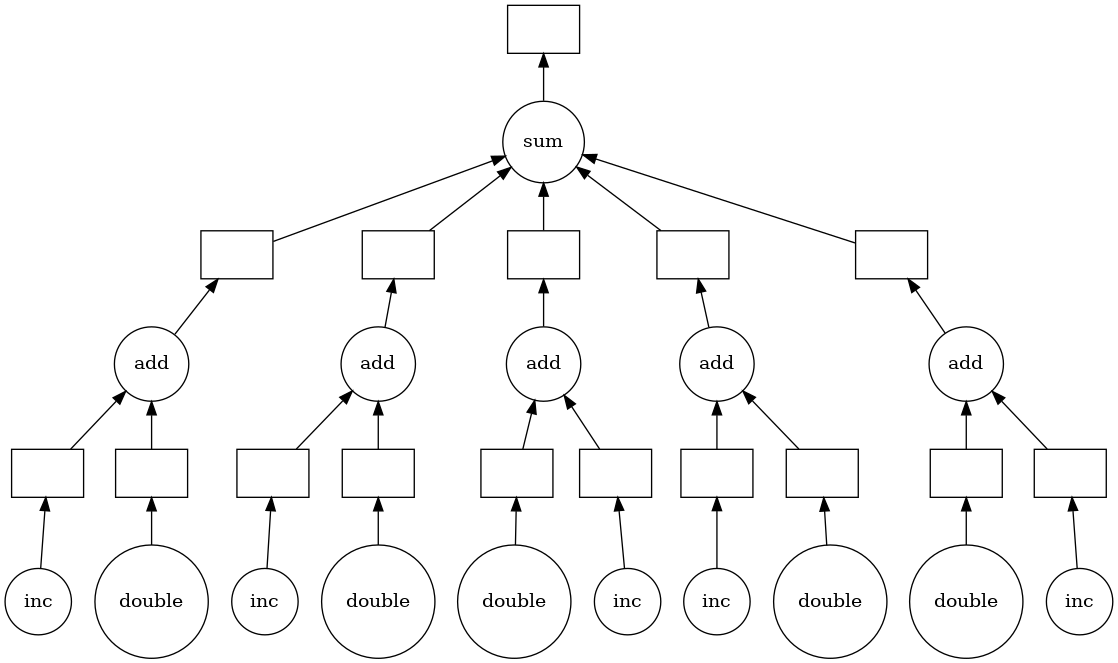

In [94]:
total.visualize()

In [96]:
%%time

total.compute()

CPU times: user 14.1 ms, sys: 6.3 ms, total: 20.4 ms
Wall time: 12.2 ms


50


## VM size notes

With Dask, `614 GB` of RAM is not enough for 40 million posts...

VM & cluster set up:
```bash
96 CPUS
640 GB RAM

```


```bash


```

### time profiling

inputs:
``` python
mlflow_experiment: 	v0.4.0_use_multi_aggregates_test
n_sample_posts_files: 	5
n_sample_comments_files: 	10

aggregate_params:
  min_comment_text_len: 	10
  agg_comments_to_post_weight_col: 	None
  agg_post_to_subreddit_weight_col: 	None
  agg_post_post_weight: 	70
  agg_post_comment_weight: 	20
  agg_post_subreddit_desc_weight: 	10
```

VM & cluster set up:
```
96 CPUS
640 GB RAM

8 workers
- 12 threads per worker
- 76 GB per worker
```

### Filtered/selected logs (with `dask`)

Overview:

| Time/ETA | Step | Notes |
| --- | --- | --- |
| `0:11:43` minutes | load raw embeddings (w/o caching) | |
| `0:03:15` minutes | Load metadata (w/o caching):  |  | 
| `0:04:30` minutes | Aggegation steps (all) | Note that this might only be the time to create the dag, not necessarily the time to actually compute the data | 
| `0:37:24` minutes | Calculate similarities  |  | 
| `1:30:00` HOURS | Saving & logging files | Saving alone could take more than 1 hour... mand I'd forgotten about this | 
|  |  |  | 

| Time/ETA | Step | Notes |
| --- | --- | --- |
| `05:19:20` minutes | load raw embeddings (w/o caching) | |
| `0:03:15` minutes | Load metadata (w/o caching):  |  | 
| `0:04:30` minutes | Aggegation steps (all) | Note that this might only be the time to create the dag, not necessarily the time to actually compute the data | 
| `0:37:24` minutes | Calculate similarities  |  | 
| `1:30:00` HOURS | Saving & logging files | Saving alone could take more than 1 hour... mand I'd forgotten about this | 
|  |  |  | 


#### Pandas
```bash

05:19:20 | INFO | "  0:06:55.796617 <- Total raw embeddings load time elapsed"

```






#### Dask
Note that there's very different ETAs for saving each DF, the first 2 are really large and take a long time. The last few are smaller, so the time estimates from `tqdm` can vary a ton:
```bash
3/11 [40:25<1:14:34, 559.33s/it]   27%
9/11 [50:22<03:22, 101.02s/it]     82% 
11/11 [1:30:11<00:00, 750.74s/it] 100%
```


Getting shape of `dask df` is taking almost half of the saving time!

**TODO: REMOVE** logging df shape for now to save a ton of time!

```bash
20:54:05 | INFO | "** df_sub_level_agg_c_post_comments_and_sub_desc **"
20:54:05 | INFO | "Saving locally..."                                   # get_df_shape() starts here...
21:13:56 | INFO | "  Saving existing dask df as parquet..."             # get df_shape() ends here, ABOUT 40 MINUTES!
21:33:11 | INFO | "Logging artifact to mlflow..."                       # In contrast, SAVING the dask df only takes about 20 MINUTES!
21:33:14 | INFO | "** df_sub_level_agg_c_post_comments_and_sub_desc_similarity **"    # And logging the dfs up to GCS only takes about 3 seconds?!
21:33:14 | INFO | "Saving locally..."
21:33:14 | INFO | "Keeping index intact..."
21:33:14 | INFO | "Converting pandas to dask..."
21:33:15 | INFO | "   185.4 MB <- Memory usage"
21:33:15 | INFO | "       5	<- target Dask partitions	   40.0 <- target MB partition size"
21:33:19 | INFO | "Logging artifact to mlflow..."
21:33:22 | INFO | "** df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair **"
21:33:22 | INFO | "Saving locally..."
21:33:24 | INFO | "Converting pandas to dask..."
21:33:35 | INFO | "  10,391.8 MB <- Memory usage"
21:33:35 | INFO | "     139	<- target Dask partitions	   75.0 <- target MB partition size"
21:33:55 | INFO | "Logging artifact to mlflow..."
21:34:30 | INFO | "** df_sub_level_agg_b_post_and_comments **"

```


More details in log file:

`logs/AggregateEmbeddings/2021-10-05_195710-sample_test_lc_false-2021-10-05_195710.log`


```bash
# load raw embeddings (w/o caching): 11:43 minutes
# ---
20:01:19 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/14/2fcfefc3d5af43328168d3478b4fdeb6/artifacts/df_vect_comments"
40/40 [07:29<00:00, 8.17s/it]
20:08:49 | INFO | "  Parquet files found: 5"
20:08:49 | INFO | "  Keep only comments for posts with embeddings"
20:08:54 | INFO | "  0:11:43.326935 <- Total raw embeddings load time elapsed"


# Load metadata (w/o caching): 3:15 minutes
# ---
20:08:54 | INFO | "-- Start _load_metadata() method --"
20:08:54 | INFO | "Loading POSTS metadata..."

20:10:39 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/comments/top/2021-10-04"
100%
59/59 [01:30<00:00, 1.43s/it]
20:12:10 | INFO | "  (Delayed('int-e6188e6d-6319-487d-b054-bea8a30d912b'), 7) <- Raw META COMMENTS shape"
20:12:10 | INFO | "  0:03:15.218880 <- Total metadata loading time elapsed"


# Aggegation steps (all): 4:30 minutes
#   Note that this might only be the time to create the dag, not necessarily the time to actually compute the data
20:12:10 | INFO | "-- Start _agg_comments_to_post_level() method --"
20:12:10 | INFO | "Getting count of comments per post..."
20:12:39 | INFO | "Filtering which comments need to be averaged..."
20:13:23 | INFO | "       22,197 <- Comments that DON'T need to be averaged"
20:13:23 | INFO | "    1,087,458 <- Comments that need to be averaged"
20:13:28 | INFO | "No column to weight comments, simple mean for comments at post level"
20:13:57 | INFO | "      191,558 |  514 <- df_v_com_agg SHAPE"
20:13:57 | INFO | "  0:01:46.878385 <- Total comments to post agg loading time elapsed"
20:13:57 | INFO | "-- Start (df_posts_agg_b) _agg_posts_and_comments_to_post_level() method --"
20:13:59 | INFO | "DEFINE agg_posts_w_comments..."
...
20:16:38 | INFO | "A - posts only"
20:16:39 | INFO | "  (Delayed('int-3ee084d4-434c-4a38-aeb1-185b50648908'), 513) <- df_subs_agg_a.shape (only posts)"
20:16:39 | INFO | "B - posts + comments"
20:16:39 | INFO | "  (Delayed('int-6bd21f72-fc1d-495c-987a-1da6e4a18683'), 513) <- df_subs_agg_b.shape (posts + comments)"
20:16:39 | INFO | "C - posts + comments + sub descriptions"
20:16:40 | INFO | "  (Delayed('int-59c54047-7ac8-49cb-81b3-478b4ae5b60e'), 513) <- df_subs_agg_c.shape (posts + comments + sub description)"
20:16:40 | INFO | "  0:00:01.507065 <- Total for ALL subreddit-level agg time elapsed"


# Calculate similarities 37:24 minutes
20:16:40 | INFO | "-- Start _calculate_subreddit_similarities() method --"
20:16:40 | INFO | "A..."
20:16:56 | INFO | "  (4924, 4924) <- df_subs_agg_a_similarity.shape"
20:17:21 | INFO | "Merge distance + metadata..."
20:17:59 | INFO | "Create new df to keep only top 20 subs by distance..."
20:18:10 | INFO | "  (24240852, 11) <- df_dist_pair_meta.shape (before setting index)"
20:18:10 | INFO | "  (98480, 11) <- df_dist_pair_meta_top_only.shape (before setting index)"
...
20:54:04 | INFO | "  0:37:24.347689 <- Total for _calculate_subreddit_similarities() time elapsed"


# *** Saving & logging file: WTF? Saving alone could take more than 2 hours!! WTF?!!  ***
20:54:04 | INFO | "-- Start _save_and_log_aggregate_and_similarity_dfs() method --"
20:54:04 | INFO | "  Saving config to local path..."
20:54:04 | INFO | "  Logging config to mlflow..."
*** 3/11 [40:25<1:14:34, 559.33s/it]  27%   ***
20:54:05 | INFO | "** df_sub_level_agg_c_post_comments_and_sub_desc **"
20:54:05 | INFO | "Saving locally..."
...
21:13:56 | INFO | "  Saving existing dask df as parquet..."
21:33:11 | INFO | "Logging artifact to mlflow..."
21:33:14 | INFO | "** df_sub_level_agg_c_post_comments_and_sub_desc_similarity **"
21:33:14 | INFO | "Saving locally..."

```